<a href="https://colab.research.google.com/github/gackouhamady/MLSD-25-26-Courses/blob/main/01-Data-Engineering/BI/notebooks/06_Statistical_Machine_Learning_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Statistical Machine Learning**


In [ ]:
if (!require(dplyr)) install.packages('dplyr')
if (!require(ggplot2)) install.packages('ggplot2')
if (!require(FNN)) install.packages('FNN')

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: ggplot2

Loading required package: FNN

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘FNN’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
library(dplyr)
library(ggplot2)
library(FNN)

# K-Nearest Neighbors

## Algorithm
For each record to be classified:
1. Find $K$ records that have similar feature values.<br>
2. For **classification**, find out the majority class among those similar records, and assign that class to the new record.<br>
3. For **prediction**, find the average among those similar records, and predicts that average for the new record.

In [ ]:
# Load the data
loan200 <- read.csv(file.path('sample_data', 'loan200.csv'), stringsAsFactors=TRUE)
loan200$outcome <- ordered(loan200$outcome, levels=c('paid off', 'default'))
head(loan200)

,outcome,payment_inc_ratio,dti
,<ord>,<dbl>,<dbl>
1,NA,9.00000,22.50
2,default,5.46933,21.33
3,paid off,6.90294,8.97
4,paid off,11.14800,1.83
5,default,3.72120,10.81
6,paid off,1.89923,11.34


In [ ]:
# With K=20, predict the outcome of a 'newloan'
newloan <- loan200[1, 2:3, drop=FALSE]
knn_pred <- knn(train=loan200[-1, 2:3], test=newloan, cl=loan200[-1, 1], k=20)
knn_pred == 'paid off'

[1] TRUE

We can make a plot to represent this prediction process. The class of the cross should be predicted and the circle encompasses the nearest neighbours.

In [ ]:
## look at the nearest 20 records and create circle
# we add 1 as we excluded the first data point for prediction
nearest_points <- loan200[attr(knn_pred, 'nn.index') + 1, ]
nearest_points
dist <- attr(knn_pred, 'nn.dist')

circleFun <- function(center=c(0, 0), r=1, npoints=100){
  tt <- seq(0, 2 * pi, length.out=npoints - 1)
  xx <- center[1] + r * cos(tt)
  yy <- center[2] + r * sin(tt)
  return(data.frame(x=c(xx, xx[1]), y=c(yy, yy[1])))
}

circle_df <- circleFun(center=unlist(newloan), r=max(dist), npoints=201)

loan200_df <- loan200 # bind_cols(loan200, circle_df)
levels(loan200_df$outcome)


,outcome,payment_inc_ratio,dti
,<ord>,<dbl>,<dbl>
36,default,8.65527,22.23
183,default,9.05778,21.62
182,paid off,9.44925,23.30
86,default,8.70942,24.13
10,default,9.43396,24.15
170,default,8.02887,20.86
22,default,6.91886,22.47
200,paid off,9.64200,20.17
78,paid off,7.70160,24.57


[1] "paid off" "default"

In [ ]:
# set first entry as target - requires adding additional level to factor
levels(loan200_df$outcome) <- c(levels(loan200_df$outcome), "newloan")
loan200_df[1, 'outcome'] <- 'newloan'
head(loan200_df)
levels(nearest_points$outcome) <- levels(loan200_df$outcome)

,outcome,payment_inc_ratio,dti
,<ord>,<dbl>,<dbl>
1,newloan,9.00000,22.50
2,default,5.46933,21.33
3,paid off,6.90294,8.97
4,paid off,11.14800,1.83
5,default,3.72120,10.81
6,paid off,1.89923,11.34


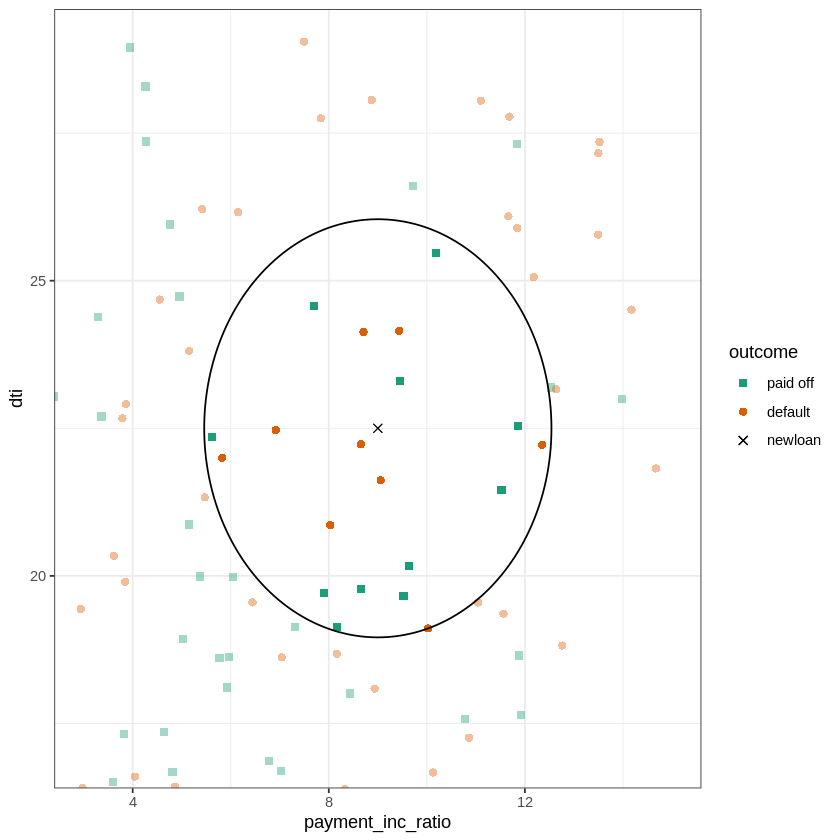

In [ ]:
graph <- ggplot(data=loan200_df, aes(x=payment_inc_ratio, y=dti, color=outcome)) + # , shape=outcome)) +
  geom_point(aes(shape=outcome), size=2, alpha=0.4) +
  geom_point(data=nearest_points, aes(shape=outcome), size=2) +
  geom_point(data=loan200_df[1,], aes(shape=outcome), size=2) +
  scale_shape_manual(values=c(15, 16, 4)) +
  scale_color_manual(values = c("paid off"="#1b9e77", "default"="#d95f02", "newloan"='black')) +
  geom_path(data=circle_df, aes(x=x, y=y), color='black') +
  coord_cartesian(xlim=c(3, 15), ylim=c(17, 29)) +
  theme_bw()
graph

# NB:
# With K = 20, we have 9 defaulted loans in the circle and 11 paid-off loans.
# Hence the cross is predicted as 'paid-off'.
#
# How is the prediction if K = 3?

**A reminder on distance**

- $\underline{Euclidean(\mathbf{x},\mathbf{u})}$ : $\sqrt{(x_1-u_1)^2+(x_2-u_2)^2+...+(x_p-u_p)^2}$; corresponds to the straight-line distance between two points.
- $\underline{Manhattan(\mathbf{x},\mathbf{u})}$ : $\vert x_1-u_1 \vert + \vert x_2-u_2 + ... + \vert x_p-u_p \vert$; distance between two points traversed in a single direction at a time.

# Standardization (Normalization, Z-Scores)

Standardization puts all variables on similar scales by subtracting the mean and dividing by the standard deviation. Thus, we ensure that a variable does not overly influence a model.
$z=\frac{x-\bar{x}}{s}$

## An example

KNN is applied to the loan data using **dti** and **payment_inc_ratio**, plus two other variables: **revol_bal** (the total revolving credit available to the applicant in dollars) and **revol_util** (the percent of the credit being used).

In [ ]:
# Load the data
loan_data <- read.csv(file.path('sample_data', 'loan_data.csv'), stringsAsFactors=TRUE)
loan_data <- select(loan_data, -X, -status)
loan_data$outcome <- ordered(loan_data$outcome, levels=c('paid off', 'default'))

In [ ]:
loan_df <- model.matrix(~ -1 + payment_inc_ratio + dti + revol_bal +
                          revol_util, data=loan_data)
newloan <- loan_df[1, , drop=FALSE]
loan_df <- loan_df[-1,]
outcome <- loan_data[-1, 1]
knn_pred <- knn(train=loan_df, test=newloan, cl=outcome, k=5)
loan_df[attr(knn_pred, "nn.index"),] # To see the top-five closest rows

# NB:
# The value of revol_bal in these neighbors is very close to its value in
# the new record, but the other predictor variables are all over the map
# and essentially play no role in determining the neighbors.

,payment_inc_ratio,dti,revol_bal,revol_util
35537,1.47212,1.46,1686,10.0
33652,3.38178,6.37,1688,8.4
25864,2.36303,1.39,1691,3.5
42954,1.28160,7.14,1684,3.9
43600,4.12244,8.98,1684,7.2


Let us compare this to KNN applied to the standardized data using the R function **scale**, which compute the $z$-score for each variable.

In [ ]:
loan_df <- model.matrix(~ -1 + payment_inc_ratio + dti + revol_bal +
                          revol_util, data=loan_data)
loan_std <- scale(loan_df)
newloan_std <- loan_std[1, , drop=FALSE]
loan_std <- loan_std[-1,]
loan_df <- loan_df[-1,]
outcome <- loan_data[-1, 1]
knn_pred <- knn(train=loan_std, test=newloan_std, cl=outcome, k=5)
loan_df[attr(knn_pred, "nn.index"),]

# NB:
# The five nearest neighbors are much more alike in all the variables, providing
# a more sensible results. Caution: the results are displayed on the original
# scale, but KNN was applied to the scaled data.

,payment_inc_ratio,dti,revol_bal,revol_util
2081,2.61091,1.03,1218,9.7
1439,2.34343,0.51,278,9.9
30216,2.71200,1.34,1075,8.5
28543,2.39760,0.74,2917,7.4
44738,2.34309,1.37,488,7.2


## Choosing $K$ in KNN

If $K$ is too low, we may be overfitting, ie. including the noise. Higher values of $K$ provide smoothong that reduce the risk of overfitting in the training. But, too high $K$ may oversmooth the data and make KNN loose its ability to capture the local structure in the data.

We can determine the best $K$ by accuracy metrics with holdout ou validation set. With little noise, small $K$ works best. For moisy data, with less structure, larger values of $K$ are appropriate.

Typically, values of $K$ fall in the range $1$ to $20$. An odd number is better to avoid ties.

*(To be extended...)*